# DEC Agglomerative Clustering

This notebook focuses on using Agglomerative Clustering instead of other types of clustering algorithms. The notebook will be extended to other algorithms like: Spectral Clustering, DBSCAN, refer to the webpage: https://scikit-learn.org/stable/modules/clustering.html

### Importing required Libaries

Importing the required libraries and modules so that they can be used in the notebook

In [1]:
import tensorflow as tf
import keras.backend as K
import numpy as np
import pandas as pd
# loading the requirements for the Xception model
from keras.applications.xception import Xception
from keras.applications.xception import absolute_import, decode_predictions, preprocess_input
from keras.layers import Flatten, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
# Loading the DEC module cloned from github
from DEC.model import *
from DEC.metrics import *
from xception_dec_datagenerator import XceptionDataGenerator
# Importing the utilities
from utils.file_utils import *
from PIL import Image
# Using scikit-image  resize function for resizing the image from original size to 224 X 224
from skimage.transform import resize
# Train Test split from sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from shutil import copy2
# For visualization of images and for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings('ignore')

### Xception Model

First we load the Xception model into the computer memory using the Keras library. Because we are focusing on extracting features from the model we do not include the topmost layer. However we do use the imagenet weights for the model. Also because we want a 1-D vector form of the features we do use the pooling layer at the end.

In [3]:
input_tensor_shape = (150, 150, 3)
base_xception_model = Xception(weights = 'imagenet', input_shape = input_tensor_shape, include_top = False, pooling='avg')
base_xception_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

The input shape of our base xception model is: 150 X 150 X 3. That is a 3 channel square image with side 150 pixels.
The output shape of the base xception model is: 2048 X 1. It is a 1-D vector representing the features learned by the model

### Data Generators

Defining the keras data generators to iterate through all the images and then essentially help in extracting the features from the images

In [4]:
image_extension = '.jpg'
training_directory_path = f'../data/xception_clustering/training/'
testing_directory_path = f'../data/xception_clustering/testing/'

In [5]:
# Getting the files already in the training and testing folders respectively
spiral_training_directory_path = construct_path(training_directory_path, 'spiral')
elliptical_training_directory_path = construct_path(training_directory_path, 'elliptical')
spiral_testing_directory_path = construct_path(testing_directory_path, 'spiral')
elliptical_testing_directory_path = construct_path(testing_directory_path, 'elliptical')
elliptical_training_files = get_file_nms(elliptical_training_directory_path, image_extension)
spiral_training_files = get_file_nms(spiral_training_directory_path, image_extension)
elliptical_testing_files = get_file_nms(elliptical_testing_directory_path, image_extension)
spiral_testing_files = get_file_nms(spiral_testing_directory_path, image_extension)
# Finding the number of images for each type of galaxy after finding the common images and list
print(f'Number of already present Training Elliptical Galaxies: {len(elliptical_training_files)}')
print(f'Number of already present Training Spiral Galaxies: {len(spiral_training_files)}')
print(f'Number of already present Testing Elliptical Galaxies: {len(elliptical_testing_files)}')
print(f'Number of already present Testing Spiral Galaxies: {len(spiral_testing_files)}')

Number of already present Training Elliptical Galaxies: 25868
Number of already present Training Spiral Galaxies: 34105
Number of already present Testing Elliptical Galaxies: 0
Number of already present Testing Spiral Galaxies: 0


#### Normalization and Cropping functions

In [6]:
def get_difference(orig_size, target_size):
    orig_size, target_size = list(orig_size), list(target_size)
    ret_ls = []
    for o, t in zip(orig_size, target_size):
        ret_ls.append(o - t)
    return ret_ls

def crop_image(image, orig_size, target_size):
    crop_sizes = get_difference(orig_size, target_size)
    height_dif, width_dif = crop_sizes[0] // 2, crop_sizes[1] // 2
    return image[height_dif:(height_dif + target_size[0]), width_dif:(width_dif + target_size[1]), :]

def range_scaling(image, out_feature_range=(-1, 1)):
    old_min, old_max = 0., 255.
    new_min, new_max = -1., 1.
    return ((image - old_min)/(old_max - old_min))*(new_max - new_min) + new_min

def image_preprocessing_function(image, crop=True, range_scale=True):
    """
    image is a 3-D image tensor (numpy array).
    """
    target_image_size = input_tensor_shape
    if crop:
        cropped_image = crop_image(image, image.shape, target_image_size)
    else:
        cropped_image = image
        
    if range_scale:
        final_image = range_scaling(cropped_image)
    else:
        final_image = cropped_image
    return final_image

#### Generator Definitions

In [7]:
%%time
generator_batch_size = 64
# Current generator uses -1 to 1
image_generator = ImageDataGenerator(preprocessing_function=image_preprocessing_function)
training_generator = image_generator.flow_from_directory(training_directory_path, target_size = input_tensor_shape[:2], 
                                                         class_mode='binary', batch_size=generator_batch_size)
testing_generator = image_generator.flow_from_directory(testing_directory_path, target_size = input_tensor_shape[:2], 
                                                         class_mode='binary', batch_size=generator_batch_size)

Found 59973 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
CPU times: user 3.55 s, sys: 656 ms, total: 4.2 s
Wall time: 2.87 s


In [8]:
%%time
n_train_examples = (len(training_generator.filenames)//generator_batch_size) * generator_batch_size
train_features = np.zeros((n_train_examples, 2048))
train_labels = np.zeros(n_train_examples, dtype=int)
i = 0
for inputs_batch, labels_batch in training_generator:
    features_batch = base_xception_model.predict(inputs_batch)
    train_features[i * generator_batch_size : (i + 1) * generator_batch_size] = features_batch
    train_labels[i * generator_batch_size : (i + 1) * generator_batch_size] = labels_batch
    i += 1
    if i % 100 == 0 and i:
        print('Number of Images processed:', i * generator_batch_size)
    if i * generator_batch_size >= n_train_examples:
        break

print('Shape of the training features', train_features.shape)

Number of Images processed: 6400
Number of Images processed: 12800
Number of Images processed: 19200
Number of Images processed: 25600
Number of Images processed: 32000
Number of Images processed: 38400
Number of Images processed: 44800
Number of Images processed: 51200
Number of Images processed: 57600
Shape of the training features (59968, 2048)
CPU times: user 6min 34s, sys: 1min 28s, total: 8min 2s
Wall time: 7min 39s


In [9]:
training_generator.class_indices

{'elliptical': 0, 'spiral': 1}

## Single-Link Agglomerative Clustering

### DEC Xception Training Regime

This part of the notebook defines the generator for the training regime of the DEC model over the features extracted from the Xception architecture

In [10]:
# Defining our DEC model
dec_model = DEC_Agglomerative([2048, 500, 500, 2000, 10], n_clusters=2)
dec_model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2048)              0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               1024500   
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 2)                 20        
Total params: 2,297,030
Trainable params: 2,297,030
Non-trainable params: 0
_________________________________________________________________


In [11]:
results_save_dir = 'results/single_link_agglomerative_clustering'
if not exist_directory(results_save_dir):
    os.makedirs(results_save_dir)

#### Pretraining

In [12]:
%%time
dec_model.pretrain(train_features, train_labels, epochs=100, save_dir=results_save_dir)

...Pretraining...
Epoch 1/100
59968/59968 [==============================] - 5s 83us/step - loss: 0.0156
        |==>  acc: 0.6207,  nmi: 0.0333  <==|
Epoch 2/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.0080
Epoch 3/100
59968/59968 [==============================] - 4s 67us/step - loss: 0.0070
Epoch 4/100
59968/59968 [==============================] - 4s 67us/step - loss: 0.0067
Epoch 5/100
59968/59968 [==============================] - 4s 67us/step - loss: 0.0065
Epoch 6/100
59968/59968 [==============================] - 4s 67us/step - loss: 0.0064
Epoch 7/100
59968/59968 [==============================] - 4s 67us/step - loss: 0.0063
Epoch 8/100
59968/59968 [==============================] - 4s 68us/step - loss: 0.0062
Epoch 9/100
59968/59968 [==============================] - 4s 67us/step - loss: 0.0061
Epoch 10/100
59968/59968 [==============================] - 4s 67us/step - loss: 0.0060
Epoch 11/100
59968/59968 [==============================] - 4s 67

#### Clustering

In [13]:
%%time
dec_model.compile(optimizer=SGD(0.01, 0.9), loss='kld')
y_pred = dec_model.fit(train_features, y=train_labels, batch_size=32, save_dir=results_save_dir, 
                       cluster_linkage='single')
print('acc:', metrics.acc(train_labels, y_pred))

Update interval 140
Save interval 9370
Initializing cluster centers with k-means.


ValueError: Unknown linkage type single.Valid options are dict_keys(['ward', 'complete', 'average'])

### Visualization of the features extracted by the DEC model

#### Encoder Output Features

CPU times: user 6.91 s, sys: 1.16 s, total: 8.07 s
Wall time: 6.56 s


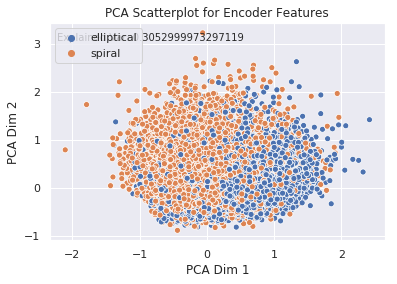

In [14]:
%%time
dec_encoder_model_pred = dec_model.encoder.predict(train_features)
pca_mod = PCA(2)
pca_mod.fit(dec_encoder_model_pred)
reduced_features = pca_mod.transform(dec_encoder_model_pred)

fig, ax = plt.subplots(1, 1)
sns.scatterplot(reduced_features[:, 0], reduced_features[:, 1], 
                hue=np.where(train_labels==0, 'elliptical', 'spiral'), ax=ax)
ax.text(0.02, 0.92, f'Explained Var: {np.round(np.sum(pca_mod.explained_variance_ratio_), decimals=4)}', 
        transform=ax.transAxes)
ax.set_xlabel('PCA Dim 1')
ax.set_ylabel('PCA Dim 2')
ax.set_title('PCA Scatterplot for Encoder Features')
plt.savefig(f'{results_save_dir}/PCAencoding_pca_features.png')

## Complete-Link Agglomerative Clustering

### DEC Xception Training Regime

This part of the notebook defines the generator for the training regime of the DEC model over the features extracted from the Xception architecture

In [15]:
# Defining our DEC model
dec_model = DEC_Agglomerative([2048, 500, 500, 2000, 10], n_clusters=2)
dec_model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2048)              0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               1024500   
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 2)                 20        
Total params: 2,297,030
Trainable params: 2,297,030
Non-trainable params: 0
_________________________________________________________________


In [16]:
results_save_dir = 'results/complete_link_agglomerative_clustering'
if not exist_directory(results_save_dir):
    os.makedirs(results_save_dir)

#### Pretraining

In [17]:
%%time
dec_model.pretrain(train_features, train_labels, epochs=100, save_dir=results_save_dir)

...Pretraining...
Epoch 1/100
59968/59968 [==============================] - 5s 86us/step - loss: 0.0150
        |==>  acc: 0.6624,  nmi: 0.0707  <==|
Epoch 2/100
59968/59968 [==============================] - 4s 69us/step - loss: 0.0079
Epoch 3/100
59968/59968 [==============================] - 4s 68us/step - loss: 0.0070
Epoch 4/100
59968/59968 [==============================] - 4s 67us/step - loss: 0.0067
Epoch 5/100
59968/59968 [==============================] - 4s 67us/step - loss: 0.0065
Epoch 6/100
59968/59968 [==============================] - 4s 67us/step - loss: 0.0063
Epoch 7/100
59968/59968 [==============================] - 4s 69us/step - loss: 0.0062
Epoch 8/100
59968/59968 [==============================] - 4s 67us/step - loss: 0.0062
Epoch 9/100
59968/59968 [==============================] - 4s 67us/step - loss: 0.0061
Epoch 10/100
59968/59968 [==============================] - 4s 67us/step - loss: 0.0060
Epoch 11/100
59968/59968 [==============================] - 4s 67

#### Clustering

In [18]:
%%time
dec_model.compile(optimizer=SGD(0.01, 0.9), loss='kld')
y_pred = dec_model.fit(train_features, y=train_labels, batch_size=32, save_dir=results_save_dir, 
                       cluster_linkage='complete')
print('acc:', metrics.acc(train_labels, y_pred))

Update interval 140
Save interval 9370
Initializing cluster centers with k-means.


AttributeError: 'AgglomerativeClustering' object has no attribute 'cluster_centers_'

### Visualization of the features extracted by the DEC model

#### Encoder Output Features

CPU times: user 6.84 s, sys: 1.08 s, total: 7.91 s
Wall time: 6.22 s


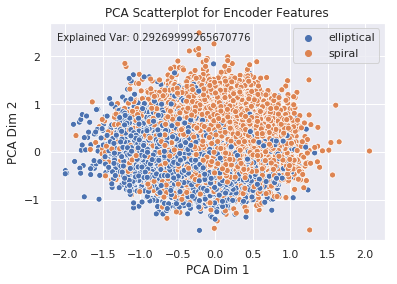

In [19]:
%%time
dec_encoder_model_pred = dec_model.encoder.predict(train_features)
pca_mod = PCA(2)
pca_mod.fit(dec_encoder_model_pred)
reduced_features = pca_mod.transform(dec_encoder_model_pred)

fig, ax = plt.subplots(1, 1)
sns.scatterplot(reduced_features[:, 0], reduced_features[:, 1], 
                hue=np.where(train_labels==0, 'elliptical', 'spiral'), ax=ax)
ax.text(0.02, 0.92, f'Explained Var: {np.round(np.sum(pca_mod.explained_variance_ratio_), decimals=4)}', 
        transform=ax.transAxes)
ax.set_xlabel('PCA Dim 1')
ax.set_ylabel('PCA Dim 2')
ax.set_title('PCA Scatterplot for Encoder Features')
plt.savefig(f'{results_save_dir}/PCAencoding_pca_features.png')

## Average-Link Agglomerative Clustering

### DEC Xception Training Regime

This part of the notebook defines the generator for the training regime of the DEC model over the features extracted from the Xception architecture

In [20]:
# Defining our DEC model
dec_model = DEC_Agglomerative([2048, 500, 500, 2000, 10], n_clusters=2)
dec_model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2048)              0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               1024500   
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 2)                 20        
Total params: 2,297,030
Trainable params: 2,297,030
Non-trainable params: 0
_________________________________________________________________


In [21]:
results_save_dir = 'results/average_link_agglomerative_clustering'
if not exist_directory(results_save_dir):
    os.makedirs(results_save_dir)

#### Pretraining

In [22]:
%%time
dec_model.pretrain(train_features, train_labels, epochs=100, save_dir=results_save_dir)

...Pretraining...
Epoch 1/100
59968/59968 [==============================] - 5s 84us/step - loss: 0.0153
        |==>  acc: 0.5925,  nmi: 0.0673  <==|
Epoch 2/100
59968/59968 [==============================] - 4s 69us/step - loss: 0.0078
Epoch 3/100
59968/59968 [==============================] - 4s 67us/step - loss: 0.0070
Epoch 4/100
59968/59968 [==============================] - 4s 67us/step - loss: 0.0067
Epoch 5/100
59968/59968 [==============================] - 4s 67us/step - loss: 0.0065
Epoch 6/100
59968/59968 [==============================] - 4s 68us/step - loss: 0.0064
Epoch 7/100
59968/59968 [==============================] - 4s 67us/step - loss: 0.0063
Epoch 8/100
59968/59968 [==============================] - 4s 67us/step - loss: 0.0062
Epoch 9/100
59968/59968 [==============================] - 4s 67us/step - loss: 0.0061
Epoch 10/100
59968/59968 [==============================] - 4s 67us/step - loss: 0.0060
Epoch 11/100
59968/59968 [==============================] - 4s 67

#### Clustering

In [23]:
%%time
dec_model.compile(optimizer=SGD(0.01, 0.9), loss='kld')
y_pred = dec_model.fit(train_features, y=train_labels, batch_size=32, save_dir=results_save_dir, 
                       cluster_linkage='average')
print('acc:', metrics.acc(train_labels, y_pred))

Update interval 140
Save interval 9370
Initializing cluster centers with k-means.


AttributeError: 'AgglomerativeClustering' object has no attribute 'cluster_centers_'

### Visualization of the features extracted by the DEC model

#### Encoder Output Features

CPU times: user 7.08 s, sys: 980 ms, total: 8.06 s
Wall time: 6.41 s


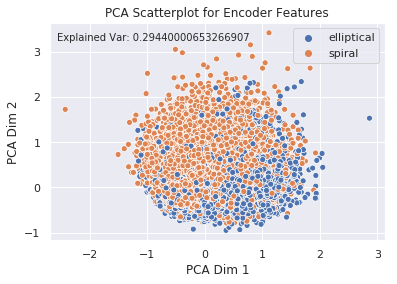

In [24]:
%%time
dec_encoder_model_pred = dec_model.encoder.predict(train_features)
pca_mod = PCA(2)
pca_mod.fit(dec_encoder_model_pred)
reduced_features = pca_mod.transform(dec_encoder_model_pred)

fig, ax = plt.subplots(1, 1)
sns.scatterplot(reduced_features[:, 0], reduced_features[:, 1], 
                hue=np.where(train_labels==0, 'elliptical', 'spiral'), ax=ax)
ax.text(0.02, 0.92, f'Explained Var: {np.round(np.sum(pca_mod.explained_variance_ratio_), decimals=4)}', 
        transform=ax.transAxes)
ax.set_xlabel('PCA Dim 1')
ax.set_ylabel('PCA Dim 2')
ax.set_title('PCA Scatterplot for Encoder Features')
plt.savefig(f'{results_save_dir}/PCAencoding_pca_features.png')

## Ward-Link Agglomerative Clustering

### DEC Xception Training Regime

This part of the notebook defines the generator for the training regime of the DEC model over the features extracted from the Xception architecture

In [25]:
# Defining our DEC model
dec_model = DEC_Agglomerative([2048, 500, 500, 2000, 10], n_clusters=2)
dec_model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2048)              0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               1024500   
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 2)                 20        
Total params: 2,297,030
Trainable params: 2,297,030
Non-trainable params: 0
_________________________________________________________________


In [26]:
results_save_dir = 'results/ward_link_agglomerative_clustering'
if not exist_directory(results_save_dir):
    os.makedirs(results_save_dir)

#### Pretraining

In [27]:
%%time
dec_model.pretrain(train_features, train_labels, epochs=100, save_dir=results_save_dir)

...Pretraining...
Epoch 1/100
59968/59968 [==============================] - 5s 89us/step - loss: 0.0153
        |==>  acc: 0.7145,  nmi: 0.1322  <==|
Epoch 2/100
59968/59968 [==============================] - 4s 69us/step - loss: 0.0081
Epoch 3/100
59968/59968 [==============================] - 4s 67us/step - loss: 0.0070
Epoch 4/100
59968/59968 [==============================] - 4s 67us/step - loss: 0.0067
Epoch 5/100
59968/59968 [==============================] - 4s 69us/step - loss: 0.0065
Epoch 6/100
59968/59968 [==============================] - 4s 68us/step - loss: 0.0064
Epoch 7/100
59968/59968 [==============================] - 4s 69us/step - loss: 0.0063
Epoch 8/100
59968/59968 [==============================] - 4s 67us/step - loss: 0.0062
Epoch 9/100
59968/59968 [==============================] - 4s 68us/step - loss: 0.0061
Epoch 10/100
59968/59968 [==============================] - 4s 69us/step - loss: 0.0061
Epoch 11/100
59968/59968 [==============================] - 4s 68

#### Clustering

In [28]:
%%time
dec_model.compile(optimizer=SGD(0.01, 0.9), loss='kld')
y_pred = dec_model.fit(train_features, y=train_labels, batch_size=32, save_dir=results_save_dir, 
                       cluster_linkage='complete')
print('acc:', metrics.acc(train_labels, y_pred))

Update interval 140
Save interval 9370
Initializing cluster centers with k-means.


AttributeError: 'AgglomerativeClustering' object has no attribute 'cluster_centers_'

### Visualization of the features extracted by the DEC model

#### Encoder Output Features

CPU times: user 7.2 s, sys: 1.05 s, total: 8.26 s
Wall time: 6.45 s


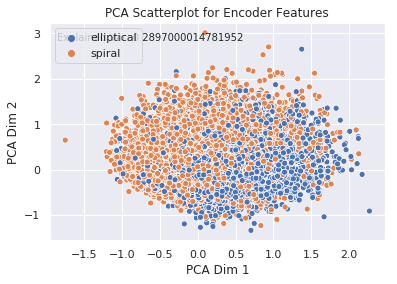

In [29]:
%%time
dec_encoder_model_pred = dec_model.encoder.predict(train_features)
pca_mod = PCA(2)
pca_mod.fit(dec_encoder_model_pred)
reduced_features = pca_mod.transform(dec_encoder_model_pred)

fig, ax = plt.subplots(1, 1)
sns.scatterplot(reduced_features[:, 0], reduced_features[:, 1], 
                hue=np.where(train_labels==0, 'elliptical', 'spiral'), ax=ax)
ax.text(0.02, 0.92, f'Explained Var: {np.round(np.sum(pca_mod.explained_variance_ratio_), decimals=4)}', 
        transform=ax.transAxes)
ax.set_xlabel('PCA Dim 1')
ax.set_ylabel('PCA Dim 2')
ax.set_title('PCA Scatterplot for Encoder Features')
plt.savefig(f'{results_save_dir}/PCAencoding_pca_features.png')